In [2]:
"""
This script runs a gridsearch and saves the results to a CSV file. This can be used on SLURM
"""

import os
import sys
try:
    task_id = int(os.environ['SLURM_ARRAY_TASK_ID'])-1 # index starts from 1!
    n_tasks = int(os.environ['SLURM_ARRAY_TASK_COUNT'])
except Exception as err:
    print(err)
    task_id = 0
    n_tasks = 1   


TEMP_SAVE= f'sweet_spot_low2.pkl' #MP


try:
    import nqcpfem
except ModuleNotFoundError:
    import sys
    sys.path.extend([r'/mnt/c/Users/olisc/NQCP/NQCP_FEM/'])
    import nqcpfem
import pandas as pd
import logging
LOGGER = logging.getLogger()

LOGGER.setLevel(logging.DEBUG)

file_formatting =logging.Formatter(fmt='- %(asctime)s: %(processName)s:%(name)s >> %(levelname)s:%(message)s', datefmt= '%Y-%m-%d %H:%M:%S')
if True:
    ch= logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    ch.setFormatter(file_formatting)
    LOGGER.addHandler(ch)

logging.getLogger('spawn').setLevel(logging.ERROR)
logging.getLogger('dist').setLevel(logging.ERROR)
logging.getLogger('build_ext').setLevel(logging.ERROR)


import numpy as np
import sympy
E0 = 1/(nqcpfem.UNIT_CONVENTION['J to eV']*1000000) # unit_scale: 1muev
from nqcpfem.solvers import PETScSolver
from nqcpfem.systems import PositionalState,DefiniteTensorComponent
from nqcpfem.envelope_function import RectangleDomain
from nqcpfem.fenics import FEniCsModel
from nqcpfem.band_model import LuttingerKohnHamiltonian
from nqcpfem.systems.dot_sc_dot import *

'SLURM_ARRAY_TASK_ID'


In [3]:
def syst_init():
    H = LuttingerKohnHamiltonian(spatial_dim=3).material_spec('Ge').add_z_confinement(1,'box',25e-9)
    H.BdG_extension()
    B = 1#np.sqrt(2)/2
    H.add_zeeman_term(B=[B/np.sqrt(2),B/np.sqrt(2),0])
    

    #H.add_potential(-sympy.symbols('\mu'))

    domain =RectangleDomain(200e-9,100e-9,0)
    domain.resolution = [100,50]

    model = FEniCsModel(H,None, boundary_condition=0,function_class=('CG',1),fix_energy_scale=True)
    omega = 2e12 # chosen so that short side of dot is around 50 nm  
    L_sc = 290e-9
    D_dot = 70e-9
    #ldot = Dot(-(D_dot/2 +1e-9+L_sc/2),omega,0,D_dot,1.44*omega,0,100e-9,)
    ldot = Dot(-( D_dot/np.sqrt(1.44)/2+ 1e-9+L_sc/2),1.44*omega,0,D_dot/np.sqrt(1.44),omega,0,100e-9,)
    rdot = Dot(( D_dot/np.sqrt(1.44)/2+ 1e-9+L_sc/2),1.44*omega,0,D_dot/np.sqrt(1.44),omega,0,100e-9,)
    barr = Barrier(0e-9,1000*E0) # 1 meV barrier
    barr = Barrier(0e-9,1000*E0) # 1 meV barrier
    #rbarr = Barrier(15e-9,3/(nqcpfem.UNIT_CONVENTION['J to eV']*1000))
    sc = Superconductor(100*E0,L_sc,100e-9,0,5*E0)
    from nqcpfem import _m_e
    sc = Superconductor(0*E0,L_sc,150e-9,0,(1.44**2+1)*_m_e/2*(omega)**2*(70e-9)**2)
    
    #rbarr = Barrier(15e-9,3/(nqcpfem.UNIT_CONVENTION['J to eV']*1000))
    sc = Superconductor(100*E0,L_sc,100e-9,0,5*E0)
    syst = DotSCDot(model,ldot,barr,sc,barr,rdot,domain_resolution=[150,60])

    mu,mu_sc = sympy.symbols('\mu,\mu_{sc}')
    mu_R = sympy.symbols('\mu_{R}')
    mu_L = sympy.symbols('\mu_{L}')
    chemical_potential = SymbolicFunction(sympy.Piecewise((-mu_sc,syst.domains['sc_in']),(-mu_L,syst.domains['ld_in']),(-mu_R,syst.domains['rd_in']),(0,True)),'\mu(x)')
    H.add_potential(chemical_potential)

    H.parameter_dict[mu_L] = 0*E0 # will be set to something other than zero on determining couping
    H.parameter_dict[mu_R] = 0*E0 # will be set to something other than zero on determining couping
    H.parameter_dict[mu_sc] = 0

    #minimizations = syst.determine_all_couplings(0,3,solver,425*E0,(-50*E0,50*E0))
    return syst

syst = syst_init() # initialize before to get easier access.

from nqcpfem.solvers import PETScSolver,IterativeSolver
solver = PETScSolver(k=16,which='SM',sigma=0)

def system_update(mu_sc_val):
    mu_R = sympy.symbols('\mu_{R}')
    mu,mu_sc = sympy.symbols('\mu,\mu_{sc}')
    mu_L = sympy.symbols('\mu_{L}')
    syst.envelope_model.band_model.parameter_dict[mu_sc] = mu_sc_val

    
    return syst

from nqcpfem.parameter_search import IterativeModelSolver,ParameterSearch


def model_eval(mu_sc_val,mu_R_val):
    
    mu_R = sympy.symbols('\mu_{R}')
    S = system_update(mu_sc_val)
    S.envelope_model.band_model.parameter_dict[mu_R] = mu_R_val #4600*E0#+150*E0#,150*E0)
    return S.envelope_model

def drop_eigenstates(model,res):
    return res[0]

it_solver = IterativeModelSolver(model_eval,solver)
    

- 2023-11-29 09:09:31: MainProcess:nqcpfem.fenics >> WARNING:the k-ordering of the band model must be FEM, but it was not set. setting it to FEM wit left reduction direction


In [8]:

mu_sc_values = np.linspace(4350,4450,8)*E0 # Log mu sweet_spot zoom

mu_R = sympy.symbols('\mu_{R}')
mu,mu_sc = sympy.symbols('\mu,\mu_{sc}')
mu_L = sympy.symbols('\mu_{L}')
S=system_update(4000*E0)
S.envelope_model.band_model.parameter_dict[mu_L] = 9410*E0#,(-150*E0,150*E0)
S.envelope_model.band_model.parameter_dict[mu_R] = 9410*E0+35*E0#+150*E0#,150*E0)
#R_low = solver.solve(S.envelope_model)

In [6]:
import pyvista
pyvista.set_jupyter_backend('static')
from nqcpfem.plotting import plot_eigenvector

- 2023-11-29 09:10:16: MainProcess:matplotlib >> DEBUG:matplotlib data path: /home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/matplotlib/mpl-data
- 2023-11-29 09:10:16: MainProcess:matplotlib >> DEBUG:CONFIGDIR=/home/oliver/.config/matplotlib
- 2023-11-29 09:10:16: MainProcess:matplotlib >> DEBUG:interactive is False
- 2023-11-29 09:10:16: MainProcess:matplotlib >> DEBUG:platform is linux
- 2023-11-29 09:10:16: MainProcess:matplotlib >> DEBUG:CACHEDIR=/home/oliver/.cache/matplotlib
- 2023-11-29 09:10:16: MainProcess:matplotlib.font_manager >> DEBUG:Using fontManager instance from /home/oliver/.cache/matplotlib/fontlist-v330.json


In [5]:
print(R_low[0]/E0)

[ -24.34246352   24.34246352  -50.57875439   50.57875439  -71.00555576
   71.00555576  -96.92540452   96.92540452  174.71466722 -174.71466722
  193.98070599 -193.98070599  227.42389554 -227.42389554  236.54050904
 -236.54050904]


In [20]:
basis_states = {'plu':5,'hrd':6,'pru':7,'hru':2,'prd':3} #up is the low energy one, 

In [21]:
basis_states = {k:R_low[1][i] for k,i in basis_states.items()}
import pickle as pkl
with open('symmetric_dots_290nm_150x60.pkl','wb') as f:
    pkl.dump(basis_states,f)
    

In [4]:
import pickle as pkl
with open('/mnt/c/Users/olisc/NQCP/NQCP_FEM/slurm/small_dots/290/small_dots_290nm_150x60.pkl','rb') as f:
    basis_states = pkl.load(f)

In [5]:
R_low[0]/E0

NameError: name 'R_low' is not defined

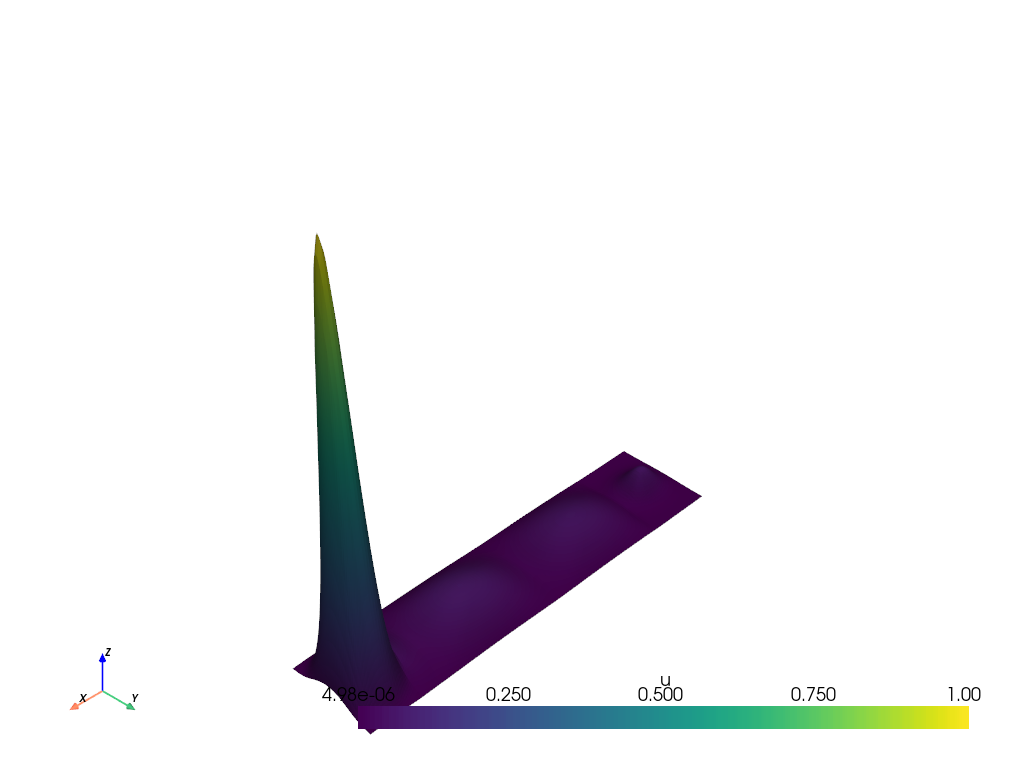

P: 21.477282813417144
H: 193.87316657029382
AM: [-1.06974492e-01 -8.59533852e-02 -5.38438015e-13]


In [16]:
#psi = R_low[1][7]
psi = basis_states['hrd']
from nqcpfem.observables import band_angular_momentum
from nqcpfem import _hbar
AM = band_angular_momentum(S.envelope_model.band_model)
plot_eigenvector(psi,S.envelope_model)
print('P:',np.linalg.norm(psi[:4]))
print('H:',np.linalg.norm(psi[4:]))
print('AM:',AM.mel(psi)/_hbar)

In [7]:
from nqcpfem.systems.dot_sc_dot import make_B_eigenstates
big_spins = np.array([[1,0,0,0],[0,0,0,1]])

B = np.sqrt(2)/2
Bvec = [B/np.sqrt(2),B/np.sqrt(2),0]
rotated = make_B_eigenstates(*Bvec)@big_spins
print(rotated)
spin_up_I = rotated[0,:,np.newaxis]
spin_down_I = rotated[1,:,np.newaxis]

[[ 0.5       -0.5j  0.        +0.j   0.        +0.j  -0.5       +0.5j]
 [ 0.70710678+0.j   0.        +0.j   0.        +0.j   0.70710678+0.j ]]


In [10]:
 mask_template = lambda x: np.zeros(syst.envelope_model.solution_shape()[:-1],dtype='complex')
N = spin_up_I.shape[0]

up_p_mask = mask_template(None)
up_p_mask[:N] = spin_up_I
up_p_state = SpinorProjection(up_p_mask,'spin up particle',axis=0)


down_p_mask = mask_template(None)
up_p_mask[:N] = spin_down_I
down_p_state = SpinorProjection(down_p_mask,'spin down particle',axis=0)

up_h_mask = mask_template(None)
ph_shift = int(up_h_mask.shape[0]/2)
up_h_mask[ph_shift:] = spin_up_I.conj()

up_h_state = SpinorProjection(up_h_mask,'spin up hole',axis=0)


down_h_mask = mask_template(None)
up_h_mask[ph_shift:] = spin_down_I.conj()
down_h_state = SpinorProjection(down_h_mask,'spin down hole',axis=0)
left,right,sc = syst.__make_system_classes__()


# step 2: Determine Tuu by detuning around mL = mR with s(pick spin up lef and spin up right stateClasses)
left_up = left.combine_state_cls(up_p_state,'left up particle')
right_up = right.combine_state_cls(up_p_state,'right up particle')

right_down = right.combine_state_cls(down_p_state,'right down particle')

right_h_down = right.combine_state_cls(down_h_state,'right down anit-particle')
right_h_up = right.combine_state_cls(up_h_state,'right up anit-particle')



In [11]:
ts=(left_up,right_up)
X_arr = syst.envelope_model.positional_rep(R_low[1][0])[1]
W=syst.subspace_weights(ts,R_low[1],x_points=X_arr).T

- 2023-11-08 09:19:02: MainProcess:nqcpfem.band_model >> DEBUG:finding eigenvalues
- 2023-11-08 09:19:02: MainProcess:nqcpfem.band_model >> DEBUG:building numerical array


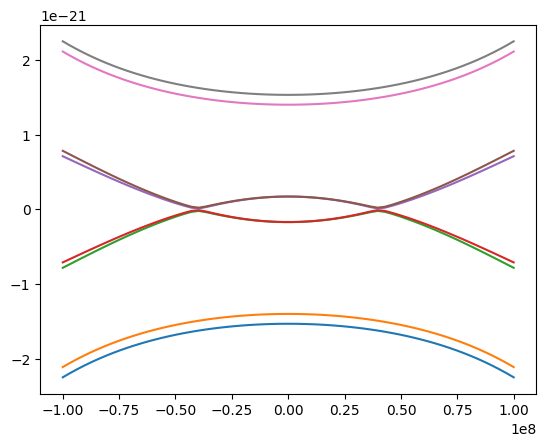

In [37]:
from matplotlib import pyplot as plt
plt.plot(*S.envelope_model.band_model.spectrum((-1e8,1e8),[0,1],64))

In [53]:
R_low[0][[0,2]]/E0

ext = np.zeros((8,1),dtype='complex')
ext[:4] = #spin_up_I
print(np.linalg.norm(np.einsum('ij,ijk->k',ext.conj(),R_low[1][0]))/np.linalg.norm(R_low[1][0]))
print(np.linalg.norm(np.einsum('ij,ijk->k',ext.conj(),R_low[1][2]))/np.linalg.norm(R_low[1][2]))

0.7172392873103071
0.6926798762595752


In [ ]:
# pick the 4 states that are mostly in the left dot

In [62]:
v=make_B_eigenstates(*[1,1,0])[1].T

In [63]:
M = np.array([[0,1-1j],[1+1j,0]])

In [64]:
v.conj()@M@v.T

(0.9999999999999998+0j)

In [22]:
R=S.perturbative_selection_couplings(model_basis,solver,4600*E0,(-150*E0,150*E0),method='signed')

<bound method DotSCDot.perturbative_selection_couplings of <nqcpfem.systems.dot_sc_dot.DotSCDot object at 0x7f97ebe1e140>>

In [27]:
mu_sc_vals = [4297.244094*E0,4318.503937*E0]
mu_R_vals = np.linspace(-100,100,512)
params = tuple({'mu_sc_val':msc, 'mu_R_val':mr} for msc in mu_sc_vals for mr in mu_R_vals)
#param_search = ParameterSearch(params,it_solver,'debug_optim_outlier.save')
param_search = ParameterSearch.load('debug_optim_outlier.save',it_solver)

EOFError: Ran out of input

In [4]:
param_search.run()

- 2023-11-06 08:13:13: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 1/1024
- 2023-11-06 08:13:13: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -100.0}
- 2023-11-06 08:13:13: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:13:13: MainProcess:nqcpfem.fenics >> DEBUG:gathering bilinear_form
- 2023-11-06 08:13:13: MainProcess:nqcpfem.fenics >> DEBUG:computing ufl_form


1


- 2023-11-06 08:13:16: MainProcess:nqcpfem.fenics >> DEBUG:creating constants dict
- 2023-11-06 08:13:27: MainProcess:root >> INFO:running build_ext
- 2023-11-06 08:13:27: MainProcess:root >> INFO:building 'libffcx_forms_330a67cd7b92feb7ddf4bbc6f78e276bb30a1622' extension
- 2023-11-06 08:13:27: MainProcess:root >> INFO:/home/oliver/miniconda3/envs/test/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -O2 -isystem /home/oliver/miniconda3/envs/test/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/oliver/miniconda3/envs/test/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/oliver/miniconda3/envs/test/include -fPIC -I/home/oliver/miniconda3/envs/test/lib/python3.10/site-packages/ffcx/codegeneration -I/home/oliver/miniconda3/envs/test/include/python3.10 -c libffcx_forms_330a67cd7b92feb7dd

(21008, 21008)


- 2023-11-06 08:13:48: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 2/1024
- 2023-11-06 08:13:48: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -99.60861056751467}
- 2023-11-06 08:13:48: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:13:48: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:13:48: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:13:48: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:13:48: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:13:48: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:13:48: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


2


- 2023-11-06 08:13:48: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:13:56: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:13:57: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 3/1024
- 2023-11-06 08:13:57: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -99.21722113502935}
- 2023-11-06 08:13:57: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:13:57: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:13:57: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:13:57: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:13:57: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:13:57: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:13:57: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


3


- 2023-11-06 08:13:57: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:14:05: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:14:07: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 4/1024
- 2023-11-06 08:14:07: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -98.82583170254404}
- 2023-11-06 08:14:07: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:14:07: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:14:07: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:14:07: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:14:07: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:14:07: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:14:07: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


4


- 2023-11-06 08:14:07: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:14:15: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:14:16: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 5/1024
- 2023-11-06 08:14:16: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -98.43444227005871}
- 2023-11-06 08:14:16: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:14:16: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:14:16: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:14:16: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:14:16: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale


5


- 2023-11-06 08:14:16: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:14:16: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:14:16: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:14:23: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:14:24: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 6/1024
- 2023-11-06 08:14:24: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -98.04305283757338}
- 2023-11-06 08:14:24: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:14:24: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:14:24: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:14:24: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:14:24: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:14:24: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:14:24: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


6


- 2023-11-06 08:14:25: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:14:32: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:14:33: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 7/1024
- 2023-11-06 08:14:33: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -97.65166340508806}
- 2023-11-06 08:14:33: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:14:33: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:14:33: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:14:33: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:14:33: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:14:33: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:14:33: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


7


- 2023-11-06 08:14:33: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:14:41: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:14:41: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 8/1024
- 2023-11-06 08:14:41: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -97.26027397260275}
- 2023-11-06 08:14:42: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:14:42: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:14:42: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:14:42: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:14:42: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:14:42: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:14:42: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


8


- 2023-11-06 08:14:42: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:14:49: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:14:50: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 9/1024
- 2023-11-06 08:14:50: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -96.86888454011742}
- 2023-11-06 08:14:50: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:14:50: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:14:50: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:14:50: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:14:50: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:14:50: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:14:50: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


9


- 2023-11-06 08:14:50: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:14:57: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:14:58: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 10/1024
- 2023-11-06 08:14:58: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -96.4774951076321}
- 2023-11-06 08:14:58: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:14:58: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:14:58: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:14:58: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:14:58: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:14:58: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:14:58: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


10


- 2023-11-06 08:14:58: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:15:06: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:15:07: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 11/1024
- 2023-11-06 08:15:07: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -96.08610567514677}
- 2023-11-06 08:15:07: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:15:07: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:15:07: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:15:07: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:15:07: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:15:07: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:15:07: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


11


- 2023-11-06 08:15:07: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:15:12: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:15:13: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 12/1024
- 2023-11-06 08:15:13: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -95.69471624266144}
- 2023-11-06 08:15:13: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:15:13: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:15:13: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:15:13: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:15:13: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:15:13: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:15:13: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:15:13: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


12
(21008, 21008)


- 2023-11-06 08:15:17: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:15:18: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 13/1024
- 2023-11-06 08:15:18: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -95.30332681017613}
- 2023-11-06 08:15:18: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:15:18: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:15:18: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:15:18: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:15:18: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:15:18: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:15:18: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:15:18: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

13
(21008, 21008)


- 2023-11-06 08:15:23: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:15:24: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 14/1024
- 2023-11-06 08:15:24: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -94.9119373776908}
- 2023-11-06 08:15:24: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:15:24: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:15:24: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:15:24: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:15:24: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:15:24: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:15:24: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


14


- 2023-11-06 08:15:24: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:15:32: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:15:32: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 15/1024
- 2023-11-06 08:15:32: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -94.52054794520548}
- 2023-11-06 08:15:32: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:15:32: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:15:32: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:15:32: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:15:33: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:15:33: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:15:33: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


15


- 2023-11-06 08:15:33: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:15:42: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:15:43: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 16/1024
- 2023-11-06 08:15:43: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -94.12915851272015}
- 2023-11-06 08:15:43: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:15:43: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:15:43: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:15:43: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:15:43: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:15:43: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:15:43: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


16


- 2023-11-06 08:15:43: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:15:51: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:15:52: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 17/1024
- 2023-11-06 08:15:52: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -93.73776908023484}
- 2023-11-06 08:15:52: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:15:52: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:15:52: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:15:52: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:15:52: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:15:52: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:15:52: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:15:52: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


17
(21008, 21008)


- 2023-11-06 08:15:57: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:15:57: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 18/1024
- 2023-11-06 08:15:57: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -93.34637964774952}
- 2023-11-06 08:15:57: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:15:57: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:15:57: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:15:57: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:15:57: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:15:57: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:15:57: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:15:57: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

18
(21008, 21008)


- 2023-11-06 08:16:02: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:16:03: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 19/1024
- 2023-11-06 08:16:03: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -92.95499021526419}
- 2023-11-06 08:16:03: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:16:03: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:16:03: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:16:03: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:16:03: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:16:03: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:16:03: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


19


- 2023-11-06 08:16:03: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:16:08: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:16:08: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 20/1024
- 2023-11-06 08:16:08: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -92.56360078277886}
- 2023-11-06 08:16:08: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:16:08: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:16:08: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:16:08: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:16:08: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:16:08: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:16:08: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:16:08: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


20
(21008, 21008)


- 2023-11-06 08:16:13: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:16:13: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 21/1024
- 2023-11-06 08:16:13: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -92.17221135029354}
- 2023-11-06 08:16:14: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:16:14: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:16:14: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:16:14: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:16:14: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:16:14: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:16:14: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:16:14: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

21
(21008, 21008)


- 2023-11-06 08:16:18: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:16:19: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 22/1024
- 2023-11-06 08:16:19: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -91.78082191780823}
- 2023-11-06 08:16:19: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:16:19: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:16:19: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:16:19: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:16:19: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:16:19: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:16:19: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:16:19: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

22
(21008, 21008)


- 2023-11-06 08:16:23: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:16:24: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 23/1024
- 2023-11-06 08:16:24: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -91.3894324853229}
- 2023-11-06 08:16:24: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:16:24: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:16:24: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:16:24: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:16:24: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:16:24: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:16:24: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:16:24: MainProcess:nqcpfem.solvers >> DEBUG:solving pro

23
(21008, 21008)


- 2023-11-06 08:16:29: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:16:29: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 24/1024
- 2023-11-06 08:16:29: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -90.99804305283757}
- 2023-11-06 08:16:29: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:16:29: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:16:29: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:16:29: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:16:29: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:16:29: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:16:29: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:16:30: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

24
(21008, 21008)


- 2023-11-06 08:16:34: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:16:35: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 25/1024
- 2023-11-06 08:16:35: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -90.60665362035225}
- 2023-11-06 08:16:35: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:16:35: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:16:35: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:16:35: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:16:35: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:16:35: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:16:35: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:16:35: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

25
(21008, 21008)


- 2023-11-06 08:16:39: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:16:40: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 26/1024
- 2023-11-06 08:16:40: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -90.21526418786692}
- 2023-11-06 08:16:40: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:16:40: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:16:40: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:16:40: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:16:40: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:16:40: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:16:40: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


26


- 2023-11-06 08:16:40: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:16:45: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:16:46: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 27/1024
- 2023-11-06 08:16:46: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -89.82387475538161}
- 2023-11-06 08:16:46: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:16:46: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:16:46: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:16:46: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:16:46: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:16:46: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:16:46: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:16:46: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


27
(21008, 21008)


- 2023-11-06 08:16:50: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:16:51: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 28/1024
- 2023-11-06 08:16:51: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -89.43248532289628}
- 2023-11-06 08:16:51: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:16:51: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:16:51: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:16:51: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:16:51: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:16:51: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:16:51: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:16:51: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

28
(21008, 21008)


- 2023-11-06 08:16:55: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:16:56: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 29/1024
- 2023-11-06 08:16:56: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -89.04109589041096}
- 2023-11-06 08:16:56: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:16:56: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:16:56: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:16:56: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:16:56: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:16:56: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:16:56: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:16:56: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

29
(21008, 21008)


- 2023-11-06 08:17:01: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:17:02: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 30/1024
- 2023-11-06 08:17:02: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -88.64970645792563}
- 2023-11-06 08:17:02: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:17:02: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:17:02: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:17:02: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:17:02: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:17:02: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:17:02: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


30


- 2023-11-06 08:17:02: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:17:06: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:17:07: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 31/1024
- 2023-11-06 08:17:07: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -88.2583170254403}
- 2023-11-06 08:17:07: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:17:07: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:17:07: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:17:07: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:17:07: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:17:07: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:17:07: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:17:07: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


31
(21008, 21008)


- 2023-11-06 08:17:12: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:17:13: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 32/1024
- 2023-11-06 08:17:13: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -87.866927592955}
- 2023-11-06 08:17:13: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:17:13: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:17:13: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:17:13: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:17:13: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:17:13: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:17:13: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:17:13: MainProcess:nqcpfem.solvers >> DEBUG:solving prob

32
(21008, 21008)


- 2023-11-06 08:17:17: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:17:18: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 33/1024
- 2023-11-06 08:17:18: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -87.47553816046967}
- 2023-11-06 08:17:18: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:17:18: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:17:18: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:17:18: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:17:18: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:17:18: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:17:18: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


33


- 2023-11-06 08:17:18: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:17:25: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:17:26: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 34/1024
- 2023-11-06 08:17:26: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -87.08414872798434}
- 2023-11-06 08:17:26: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:17:26: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:17:26: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:17:26: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:17:26: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:17:26: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:17:26: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:17:26: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


34
(21008, 21008)


- 2023-11-06 08:17:35: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:17:37: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 35/1024
- 2023-11-06 08:17:37: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -86.69275929549903}
- 2023-11-06 08:17:37: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:17:37: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:17:37: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:17:37: MainProcess:nqcpfem.fenics >> DEBUG:updating values


35


- 2023-11-06 08:17:37: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:17:37: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:17:37: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:17:37: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:17:45: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:17:46: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 36/1024
- 2023-11-06 08:17:46: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -86.3013698630137}
- 2023-11-06 08:17:46: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:17:46: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:17:46: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:17:46: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:17:46: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:17:47: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:17:47: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:17:47: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


36
(21008, 21008)


- 2023-11-06 08:17:53: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:17:54: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 37/1024
- 2023-11-06 08:17:54: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -85.90998043052838}
- 2023-11-06 08:17:54: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:17:54: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:17:54: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:17:54: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:17:54: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:17:54: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:17:54: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:17:54: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

37
(21008, 21008)


- 2023-11-06 08:18:03: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 38/1024
- 2023-11-06 08:18:03: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -85.51859099804305}
- 2023-11-06 08:18:03: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:18:03: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:18:03: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:18:03: MainProcess:nqcpfem.fenics >> DEBUG:updating values


38


- 2023-11-06 08:18:04: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:18:04: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:18:04: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:18:04: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:18:13: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:18:14: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 39/1024
- 2023-11-06 08:18:14: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -85.12720156555773}
- 2023-11-06 08:18:14: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:18:14: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:18:14: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:18:14: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:18:14: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:18:14: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:18:14: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


39


- 2023-11-06 08:18:15: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:18:25: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:18:28: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 40/1024
- 2023-11-06 08:18:28: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -84.73581213307241}
- 2023-11-06 08:18:28: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:18:28: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:18:28: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:18:28: MainProcess:nqcpfem.fenics >> DEBUG:updating values


40


- 2023-11-06 08:18:28: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:18:28: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:18:28: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:18:28: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:18:36: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:18:40: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 41/1024
- 2023-11-06 08:18:40: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -84.34442270058709}
- 2023-11-06 08:18:40: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:18:40: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:18:40: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:18:40: MainProcess:nqcpfem.fenics >> DEBUG:updating values


41


- 2023-11-06 08:18:40: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:18:40: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:18:40: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:18:41: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:18:50: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:18:51: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 42/1024
- 2023-11-06 08:18:51: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -83.95303326810176}
- 2023-11-06 08:18:51: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:18:51: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:18:51: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:18:51: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:18:51: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:18:52: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:18:52: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


42


- 2023-11-06 08:18:52: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:18:59: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:19:01: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 43/1024
- 2023-11-06 08:19:01: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -83.56164383561644}
- 2023-11-06 08:19:01: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:19:01: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:19:01: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:19:01: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:19:01: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:19:01: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:19:01: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


43


- 2023-11-06 08:19:01: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:19:10: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:19:13: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 44/1024
- 2023-11-06 08:19:13: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -83.17025440313111}
- 2023-11-06 08:19:13: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:19:13: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:19:13: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:19:13: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:19:13: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale


44


- 2023-11-06 08:19:13: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:19:13: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:19:14: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:19:32: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:19:35: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 45/1024
- 2023-11-06 08:19:35: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -82.7788649706458}
- 2023-11-06 08:19:35: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:19:35: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:19:35: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:19:35: MainProcess:nqcpfem.fenics >> DEBUG:updating values


45


- 2023-11-06 08:19:35: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:19:35: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:19:35: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:19:36: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:19:49: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:19:51: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 46/1024
- 2023-11-06 08:19:51: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -82.38747553816047}
- 2023-11-06 08:19:51: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:19:51: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:19:51: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:19:51: MainProcess:nqcpfem.fenics >> DEBUG:updating values


46


- 2023-11-06 08:19:52: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:19:52: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:19:52: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:19:52: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:20:01: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:20:03: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 47/1024
- 2023-11-06 08:20:03: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -81.99608610567515}
- 2023-11-06 08:20:03: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:20:03: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:20:03: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:20:03: MainProcess:nqcpfem.fenics >> DEBUG:updating values


47


- 2023-11-06 08:20:03: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:20:03: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:20:03: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:20:04: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:20:14: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:20:16: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 48/1024
- 2023-11-06 08:20:16: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -81.60469667318982}
- 2023-11-06 08:20:16: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:20:16: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:20:16: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:20:16: MainProcess:nqcpfem.fenics >> DEBUG:updating values


48


- 2023-11-06 08:20:17: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:20:17: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:20:17: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:20:17: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:20:24: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:20:27: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 49/1024
- 2023-11-06 08:20:27: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -81.2133072407045}
- 2023-11-06 08:20:27: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:20:27: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:20:27: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:20:27: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:20:27: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:20:27: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:20:27: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


49


- 2023-11-06 08:20:27: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:20:34: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:20:36: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 50/1024
- 2023-11-06 08:20:36: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -80.82191780821918}
- 2023-11-06 08:20:36: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:20:36: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:20:36: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:20:36: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:20:36: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:20:36: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:20:36: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


50


- 2023-11-06 08:20:37: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:20:44: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:20:46: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 51/1024
- 2023-11-06 08:20:46: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -80.43052837573386}
- 2023-11-06 08:20:46: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:20:46: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:20:46: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:20:46: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:20:47: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:20:47: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:20:47: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


51


- 2023-11-06 08:20:47: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:20:54: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:20:57: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 52/1024
- 2023-11-06 08:20:57: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -80.03913894324853}
- 2023-11-06 08:20:57: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:20:57: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:20:57: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:20:57: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:20:57: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:20:57: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:20:57: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:20:58: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


52
(21008, 21008)


- 2023-11-06 08:21:05: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:21:08: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 53/1024
- 2023-11-06 08:21:08: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -79.64774951076322}
- 2023-11-06 08:21:08: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:21:08: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:21:08: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:21:08: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:21:08: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:21:08: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:21:08: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


53


- 2023-11-06 08:21:08: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:21:15: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:21:17: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 54/1024
- 2023-11-06 08:21:17: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -79.25636007827788}
- 2023-11-06 08:21:17: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:21:17: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:21:17: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:21:17: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:21:17: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:21:17: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:21:17: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:21:18: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


54
(21008, 21008)


- 2023-11-06 08:21:24: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:21:25: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 55/1024
- 2023-11-06 08:21:25: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -78.86497064579257}
- 2023-11-06 08:21:25: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:21:25: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:21:25: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:21:25: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:21:25: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:21:25: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:21:25: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:21:25: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

55
(21008, 21008)


- 2023-11-06 08:21:29: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:21:30: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 56/1024
- 2023-11-06 08:21:30: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -78.47358121330724}
- 2023-11-06 08:21:30: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:21:30: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:21:30: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:21:30: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:21:30: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:21:30: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:21:30: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:21:31: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

56
(21008, 21008)


- 2023-11-06 08:21:34: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:21:36: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 57/1024
- 2023-11-06 08:21:36: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -78.08219178082192}
- 2023-11-06 08:21:36: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:21:36: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:21:36: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:21:36: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:21:36: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:21:36: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:21:36: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:21:36: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

57
(21008, 21008)


- 2023-11-06 08:21:40: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:21:41: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 58/1024
- 2023-11-06 08:21:41: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -77.6908023483366}
- 2023-11-06 08:21:41: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:21:41: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:21:41: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:21:41: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:21:41: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:21:41: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:21:41: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:21:41: MainProcess:nqcpfem.solvers >> DEBUG:solving pro

58
(21008, 21008)


- 2023-11-06 08:21:45: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:21:46: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 59/1024
- 2023-11-06 08:21:46: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -77.29941291585128}
- 2023-11-06 08:21:46: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:21:46: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:21:46: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:21:46: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:21:46: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:21:46: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:21:46: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:21:47: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

59
(21008, 21008)


- 2023-11-06 08:21:52: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:21:54: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 60/1024
- 2023-11-06 08:21:54: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -76.90802348336595}
- 2023-11-06 08:21:54: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:21:54: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:21:54: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:21:54: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:21:54: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:21:54: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:21:54: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:21:54: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

60
(21008, 21008)


- 2023-11-06 08:22:00: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:22:01: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 61/1024
- 2023-11-06 08:22:01: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -76.51663405088063}
- 2023-11-06 08:22:01: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:22:01: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:22:02: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:22:02: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:22:02: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:22:02: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:22:02: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:22:02: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

61
(21008, 21008)


- 2023-11-06 08:22:08: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:22:10: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 62/1024
- 2023-11-06 08:22:10: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -76.1252446183953}
- 2023-11-06 08:22:10: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:22:10: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:22:10: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:22:10: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:22:10: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:22:10: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:22:10: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:22:10: MainProcess:nqcpfem.solvers >> DEBUG:solving pro

62
(21008, 21008)


- 2023-11-06 08:22:16: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:22:17: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 63/1024
- 2023-11-06 08:22:17: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -75.73385518590999}
- 2023-11-06 08:22:17: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:22:17: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:22:17: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:22:17: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:22:17: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:22:17: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:22:17: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:22:17: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

63
(21008, 21008)


- 2023-11-06 08:22:23: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:22:25: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 64/1024
- 2023-11-06 08:22:25: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -75.34246575342466}
- 2023-11-06 08:22:25: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:22:25: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:22:25: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:22:25: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:22:25: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:22:25: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:22:25: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:22:25: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

64
(21008, 21008)


- 2023-11-06 08:22:31: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:22:33: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 65/1024
- 2023-11-06 08:22:33: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -74.95107632093934}
- 2023-11-06 08:22:33: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:22:33: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:22:33: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:22:33: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:22:33: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:22:33: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:22:33: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:22:33: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

65
(21008, 21008)


- 2023-11-06 08:22:40: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:22:41: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 66/1024
- 2023-11-06 08:22:41: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -74.55968688845401}
- 2023-11-06 08:22:41: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:22:41: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:22:41: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:22:41: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:22:41: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:22:41: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:22:41: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:22:41: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

66
(21008, 21008)


- 2023-11-06 08:22:48: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:22:49: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 67/1024
- 2023-11-06 08:22:49: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -74.16829745596868}
- 2023-11-06 08:22:49: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:22:49: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:22:49: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:22:49: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:22:49: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:22:49: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:22:49: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:22:49: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

67
(21008, 21008)


- 2023-11-06 08:22:56: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:22:58: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 68/1024
- 2023-11-06 08:22:58: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -73.77690802348337}
- 2023-11-06 08:22:58: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:22:58: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:22:58: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:22:58: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:22:58: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:22:58: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:22:58: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:22:58: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

68
(21008, 21008)


- 2023-11-06 08:23:05: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:23:06: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 69/1024
- 2023-11-06 08:23:06: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -73.38551859099805}
- 2023-11-06 08:23:06: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:23:06: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:23:06: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:23:06: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:23:07: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:23:07: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:23:07: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:23:07: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

69
(21008, 21008)


- 2023-11-06 08:23:13: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:23:15: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 70/1024
- 2023-11-06 08:23:15: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -72.99412915851272}
- 2023-11-06 08:23:15: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:23:15: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:23:15: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:23:15: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:23:15: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:23:15: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:23:15: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:23:15: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

70
(21008, 21008)


- 2023-11-06 08:23:21: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:23:23: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 71/1024
- 2023-11-06 08:23:23: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -72.6027397260274}
- 2023-11-06 08:23:23: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:23:23: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:23:23: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:23:23: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:23:23: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:23:23: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:23:23: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:23:23: MainProcess:nqcpfem.solvers >> DEBUG:solving pro

71
(21008, 21008)


- 2023-11-06 08:23:29: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:23:31: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 72/1024
- 2023-11-06 08:23:31: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -72.21135029354207}
- 2023-11-06 08:23:31: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:23:31: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:23:31: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:23:31: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:23:31: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:23:31: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:23:31: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:23:31: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

72
(21008, 21008)


- 2023-11-06 08:23:38: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:23:40: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 73/1024
- 2023-11-06 08:23:40: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -71.81996086105676}
- 2023-11-06 08:23:40: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:23:40: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:23:40: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:23:40: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:23:40: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:23:40: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:23:40: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:23:40: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

73
(21008, 21008)


- 2023-11-06 08:23:47: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:23:49: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 74/1024
- 2023-11-06 08:23:49: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -71.42857142857143}
- 2023-11-06 08:23:49: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:23:49: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:23:49: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:23:49: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:23:49: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:23:49: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:23:49: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:23:49: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

74
(21008, 21008)


- 2023-11-06 08:23:55: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:23:58: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 75/1024
- 2023-11-06 08:23:58: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -71.0371819960861}
- 2023-11-06 08:23:58: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:23:58: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:23:58: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:23:58: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:23:58: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:23:58: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:23:58: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:23:58: MainProcess:nqcpfem.solvers >> DEBUG:solving pro

75
(21008, 21008)


- 2023-11-06 08:24:05: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:24:08: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 76/1024
- 2023-11-06 08:24:08: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -70.64579256360079}
- 2023-11-06 08:24:08: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:24:08: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:24:08: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:24:08: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:24:08: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:24:08: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:24:08: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:24:08: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

76
(21008, 21008)


- 2023-11-06 08:24:14: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:24:16: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 77/1024
- 2023-11-06 08:24:16: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -70.25440313111545}
- 2023-11-06 08:24:16: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:24:16: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:24:16: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:24:16: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:24:16: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:24:16: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:24:16: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


77


- 2023-11-06 08:24:16: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:24:23: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:24:25: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 78/1024
- 2023-11-06 08:24:25: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -69.86301369863014}
- 2023-11-06 08:24:25: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:24:25: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:24:25: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:24:26: MainProcess:nqcpfem.fenics >> DEBUG:updating values


78


- 2023-11-06 08:24:26: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:24:26: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:24:26: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:24:26: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:24:34: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:24:38: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 79/1024
- 2023-11-06 08:24:38: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -69.47162426614481}
- 2023-11-06 08:24:38: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:24:38: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:24:38: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:24:38: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:24:38: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:24:38: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:24:38: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


79


- 2023-11-06 08:24:38: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:24:46: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:24:48: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 80/1024
- 2023-11-06 08:24:48: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -69.08023483365949}
- 2023-11-06 08:24:48: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:24:48: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:24:48: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:24:48: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:24:48: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:24:48: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:24:48: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:24:49: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


80
(21008, 21008)


- 2023-11-06 08:24:59: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:25:02: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 81/1024
- 2023-11-06 08:25:02: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -68.68884540117418}
- 2023-11-06 08:25:02: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:25:02: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:25:02: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:25:02: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:25:02: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:25:02: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:25:02: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


81


- 2023-11-06 08:25:02: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:25:13: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:25:17: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 82/1024
- 2023-11-06 08:25:17: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -68.29745596868885}
- 2023-11-06 08:25:17: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:25:17: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:25:17: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:25:17: MainProcess:nqcpfem.fenics >> DEBUG:updating values


82


- 2023-11-06 08:25:17: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:25:17: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:25:17: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:25:18: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:25:26: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:25:29: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 83/1024
- 2023-11-06 08:25:29: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -67.90606653620353}
- 2023-11-06 08:25:29: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:25:29: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:25:29: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:25:29: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:25:29: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:25:29: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:25:29: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


83


- 2023-11-06 08:25:29: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:25:37: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:25:40: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 84/1024
- 2023-11-06 08:25:40: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -67.5146771037182}
- 2023-11-06 08:25:40: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:25:40: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:25:40: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:25:40: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:25:40: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:25:40: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:25:40: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


84


- 2023-11-06 08:25:40: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:25:49: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:25:52: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 85/1024
- 2023-11-06 08:25:52: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -67.12328767123287}
- 2023-11-06 08:25:52: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:25:52: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:25:52: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:25:52: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:25:52: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:25:52: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:25:52: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:25:52: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


85
(21008, 21008)


- 2023-11-06 08:25:59: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:26:01: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 86/1024
- 2023-11-06 08:26:01: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -66.73189823874756}
- 2023-11-06 08:26:01: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:26:01: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:26:01: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:26:01: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:26:01: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:26:01: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:26:01: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


86


- 2023-11-06 08:26:02: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:26:10: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:26:12: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 87/1024
- 2023-11-06 08:26:12: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -66.34050880626224}
- 2023-11-06 08:26:12: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:26:12: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:26:12: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:26:12: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:26:12: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:26:12: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:26:12: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


87


- 2023-11-06 08:26:13: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:26:20: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:26:24: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 88/1024
- 2023-11-06 08:26:24: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -65.94911937377691}
- 2023-11-06 08:26:24: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:26:24: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:26:24: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:26:24: MainProcess:nqcpfem.fenics >> DEBUG:updating values


88


- 2023-11-06 08:26:24: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:26:24: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:26:24: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:26:25: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:26:36: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:26:41: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 89/1024
- 2023-11-06 08:26:41: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -65.55772994129158}
- 2023-11-06 08:26:41: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:26:41: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:26:41: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:26:41: MainProcess:nqcpfem.fenics >> DEBUG:updating values


89


- 2023-11-06 08:26:41: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:26:41: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:26:42: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:26:42: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:26:54: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:26:59: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 90/1024
- 2023-11-06 08:26:59: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -65.16634050880626}
- 2023-11-06 08:26:59: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:26:59: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:26:59: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:26:59: MainProcess:nqcpfem.fenics >> DEBUG:updating values


90


- 2023-11-06 08:26:59: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:26:59: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:26:59: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:27:00: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


(21008, 21008)


- 2023-11-06 08:27:10: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:27:14: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 91/1024
- 2023-11-06 08:27:14: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -64.77495107632095}
- 2023-11-06 08:27:14: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:27:14: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:27:14: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:27:14: MainProcess:nqcpfem.fenics >> DEBUG:updating values


91


- 2023-11-06 08:27:14: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:27:14: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:27:14: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:27:14: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:27:25: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:27:29: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 92/1024
- 2023-11-06 08:27:29: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -64.38356164383562}
- 2023-11-06 08:27:29: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:27:29: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:27:29: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:27:29: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:27:29: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:27:29: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:27:29: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


92


- 2023-11-06 08:27:29: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:27:38: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:27:41: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 93/1024
- 2023-11-06 08:27:41: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -63.992172211350294}
- 2023-11-06 08:27:41: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:27:41: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:27:41: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:27:41: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:27:41: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:27:41: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:27:41: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


93


- 2023-11-06 08:27:41: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:27:48: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:27:51: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 94/1024
- 2023-11-06 08:27:51: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -63.600782778864975}
- 2023-11-06 08:27:51: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:27:51: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:27:51: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:27:51: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:27:51: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:27:51: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:27:51: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:27:51: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


94
(21008, 21008)


- 2023-11-06 08:27:58: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:28:01: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 95/1024
- 2023-11-06 08:28:01: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -63.20939334637965}
- 2023-11-06 08:28:01: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:28:01: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:28:01: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:28:01: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:28:01: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:28:01: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:28:01: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:28:01: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

95
(21008, 21008)


- 2023-11-06 08:28:09: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:28:11: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 96/1024
- 2023-11-06 08:28:11: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -62.81800391389433}
- 2023-11-06 08:28:11: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:28:11: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:28:11: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:28:11: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:28:11: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:28:11: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:28:11: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:28:11: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

96
(21008, 21008)


- 2023-11-06 08:28:18: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:28:21: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 97/1024
- 2023-11-06 08:28:21: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -62.426614481409004}
- 2023-11-06 08:28:21: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:28:21: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:28:21: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:28:21: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:28:21: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:28:21: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:28:21: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:28:21: MainProcess:nqcpfem.solvers >> DEBUG:solving p

97
(21008, 21008)


- 2023-11-06 08:28:28: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:28:30: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 98/1024
- 2023-11-06 08:28:30: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -62.03522504892368}
- 2023-11-06 08:28:30: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:28:30: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:28:30: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:28:30: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:28:30: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:28:30: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:28:30: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:28:31: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

98
(21008, 21008)


- 2023-11-06 08:28:38: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:28:41: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 99/1024
- 2023-11-06 08:28:41: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -61.64383561643836}
- 2023-11-06 08:28:41: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:28:41: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:28:41: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:28:41: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:28:41: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:28:41: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:28:41: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:28:41: MainProcess:nqcpfem.solvers >> DEBUG:solving pr

99
(21008, 21008)


- 2023-11-06 08:28:47: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:28:50: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 100/1024
- 2023-11-06 08:28:50: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -61.25244618395303}
- 2023-11-06 08:28:50: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:28:50: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:28:50: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:28:50: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:28:50: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:28:50: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:28:50: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:28:50: MainProcess:nqcpfem.solvers >> DEBUG:solving p

100
(21008, 21008)


- 2023-11-06 08:28:56: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:29:00: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 101/1024
- 2023-11-06 08:29:00: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -60.861056751467714}
- 2023-11-06 08:29:00: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:29:00: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:29:00: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:29:00: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:29:00: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:29:00: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:29:00: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:29:00: MainProcess:nqcpfem.solvers >> DEBUG:solving 

101
(21008, 21008)


- 2023-11-06 08:29:07: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:29:11: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 102/1024
- 2023-11-06 08:29:11: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -60.46966731898239}
- 2023-11-06 08:29:11: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:29:11: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:29:11: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:29:11: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:29:11: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:29:11: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:29:11: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:29:11: MainProcess:nqcpfem.solvers >> DEBUG:solving p

102
(21008, 21008)


- 2023-11-06 08:29:22: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:29:25: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 103/1024
- 2023-11-06 08:29:25: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -60.07827788649707}
- 2023-11-06 08:29:25: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:29:25: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:29:25: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:29:25: MainProcess:nqcpfem.fenics >> DEBUG:updating values


103


- 2023-11-06 08:29:26: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:29:26: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:29:26: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:29:26: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:29:33: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:29:35: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 104/1024
- 2023-11-06 08:29:35: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -59.68688845401174}
- 2023-11-06 08:29:35: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:29:35: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:29:35: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:29:35: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:29:35: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:29:35: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:29:35: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:29:36: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


104
(21008, 21008)


- 2023-11-06 08:29:44: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:29:46: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 105/1024
- 2023-11-06 08:29:46: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -59.295499021526425}
- 2023-11-06 08:29:46: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:29:46: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:29:46: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:29:46: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:29:46: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:29:46: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:29:46: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


105


- 2023-11-06 08:29:46: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:29:53: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:29:55: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 106/1024
- 2023-11-06 08:29:55: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -58.9041095890411}
- 2023-11-06 08:29:55: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:29:55: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:29:55: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:29:55: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:29:55: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:29:55: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:29:55: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:29:55: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


106
(21008, 21008)


- 2023-11-06 08:30:04: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:30:08: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 107/1024
- 2023-11-06 08:30:08: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -58.51272015655577}
- 2023-11-06 08:30:08: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:30:08: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:30:08: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:30:08: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:30:08: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:30:08: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:30:08: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:30:08: MainProcess:nqcpfem.solvers >> DEBUG:solving p

107
(21008, 21008)


- 2023-11-06 08:30:20: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:30:22: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 108/1024
- 2023-11-06 08:30:22: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -58.121330724070454}
- 2023-11-06 08:30:22: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:30:22: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:30:22: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:30:22: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:30:22: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:30:22: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:30:22: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:30:22: MainProcess:nqcpfem.solvers >> DEBUG:solving 

108
(21008, 21008)


- 2023-11-06 08:30:30: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:30:33: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 109/1024
- 2023-11-06 08:30:33: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -57.72994129158513}
- 2023-11-06 08:30:33: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:30:33: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:30:33: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:30:33: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:30:33: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:30:33: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:30:33: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:30:33: MainProcess:nqcpfem.solvers >> DEBUG:solving p

109
(21008, 21008)


- 2023-11-06 08:30:40: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:30:43: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 110/1024
- 2023-11-06 08:30:43: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -57.33855185909981}
- 2023-11-06 08:30:43: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:30:43: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:30:43: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:30:43: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:30:43: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:30:43: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:30:43: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:30:43: MainProcess:nqcpfem.solvers >> DEBUG:solving p

110
(21008, 21008)


- 2023-11-06 08:30:51: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:30:54: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 111/1024
- 2023-11-06 08:30:54: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -56.94716242661448}
- 2023-11-06 08:30:54: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:30:54: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:30:54: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:30:54: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:30:54: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:30:54: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:30:54: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:30:54: MainProcess:nqcpfem.solvers >> DEBUG:solving p

111
(21008, 21008)


- 2023-11-06 08:31:02: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:31:05: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 112/1024
- 2023-11-06 08:31:05: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -56.555772994129164}
- 2023-11-06 08:31:05: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:31:05: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:31:05: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:31:05: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:31:05: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:31:05: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:31:05: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:31:05: MainProcess:nqcpfem.solvers >> DEBUG:solving 

112
(21008, 21008)


- 2023-11-06 08:31:13: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:31:16: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 113/1024
- 2023-11-06 08:31:16: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -56.16438356164384}
- 2023-11-06 08:31:16: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:31:16: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:31:16: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:31:16: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:31:16: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale


113


- 2023-11-06 08:31:16: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:31:16: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:31:17: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:31:24: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:31:27: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 114/1024
- 2023-11-06 08:31:27: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -55.77299412915851}
- 2023-11-06 08:31:27: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:31:27: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:31:27: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:31:27: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:31:27: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:31:27: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:31:27: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


114


- 2023-11-06 08:31:28: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:31:34: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:31:38: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 115/1024
- 2023-11-06 08:31:38: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -55.38160469667319}
- 2023-11-06 08:31:38: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:31:38: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:31:38: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:31:38: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:31:38: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:31:38: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:31:38: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


115


- 2023-11-06 08:31:38: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:31:45: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:31:50: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 116/1024
- 2023-11-06 08:31:50: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -54.99021526418787}
- 2023-11-06 08:31:50: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:31:50: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:31:50: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:31:50: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:31:50: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:31:50: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:31:50: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


116


- 2023-11-06 08:31:50: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:31:58: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:32:01: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 117/1024
- 2023-11-06 08:32:01: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -54.59882583170255}
- 2023-11-06 08:32:01: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:32:01: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:32:01: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:32:01: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:32:01: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:32:01: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:32:01: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


117


- 2023-11-06 08:32:01: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:32:10: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:32:14: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 118/1024
- 2023-11-06 08:32:14: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -54.20743639921722}
- 2023-11-06 08:32:14: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:32:14: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:32:14: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:32:14: MainProcess:nqcpfem.fenics >> DEBUG:updating values


118


- 2023-11-06 08:32:14: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:32:14: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:32:14: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:32:14: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:32:25: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:32:29: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 119/1024
- 2023-11-06 08:32:29: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -53.8160469667319}
- 2023-11-06 08:32:29: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:32:29: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:32:29: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:32:29: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:32:29: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:32:29: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:32:29: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:32:29: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


119
(21008, 21008)


- 2023-11-06 08:32:36: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:32:39: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 120/1024
- 2023-11-06 08:32:39: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -53.42465753424658}
- 2023-11-06 08:32:39: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:32:39: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:32:39: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:32:39: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:32:39: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:32:39: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:32:39: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:32:39: MainProcess:nqcpfem.solvers >> DEBUG:solving p

120
(21008, 21008)


- 2023-11-06 08:32:47: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:32:50: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 121/1024
- 2023-11-06 08:32:50: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -53.03326810176125}
- 2023-11-06 08:32:50: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:32:50: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:32:50: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:32:50: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:32:50: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:32:50: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:32:50: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:32:50: MainProcess:nqcpfem.solvers >> DEBUG:solving p

121
(21008, 21008)


- 2023-11-06 08:33:01: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 122/1024
- 2023-11-06 08:33:01: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -52.64187866927593}
- 2023-11-06 08:33:01: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:33:01: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:33:01: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:33:01: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:33:01: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:33:01: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:33:01: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


122


- 2023-11-06 08:33:01: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:33:11: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:33:15: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 123/1024
- 2023-11-06 08:33:15: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -52.25048923679061}
- 2023-11-06 08:33:15: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:33:15: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:33:15: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:33:15: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:33:15: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:33:15: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:33:15: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


123


- 2023-11-06 08:33:15: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:33:25: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:33:29: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 124/1024
- 2023-11-06 08:33:29: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -51.85909980430529}
- 2023-11-06 08:33:29: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:33:29: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:33:29: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:33:29: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:33:29: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:33:29: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:33:29: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


124


- 2023-11-06 08:33:29: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:33:39: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:33:42: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 125/1024
- 2023-11-06 08:33:42: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -51.46771037181996}
- 2023-11-06 08:33:42: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:33:42: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:33:42: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:33:42: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:33:42: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:33:42: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:33:42: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:33:42: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


125
(21008, 21008)


- 2023-11-06 08:33:49: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:33:55: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 126/1024
- 2023-11-06 08:33:55: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -51.07632093933464}
- 2023-11-06 08:33:55: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:33:55: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:33:55: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:33:55: MainProcess:nqcpfem.fenics >> DEBUG:updating values


126


- 2023-11-06 08:33:55: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:33:55: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:33:55: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:33:55: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:34:07: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:34:10: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 127/1024
- 2023-11-06 08:34:10: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -50.68493150684932}
- 2023-11-06 08:34:10: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:34:10: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:34:10: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:34:10: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:34:10: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:34:10: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:34:10: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:34:10: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


127
(21008, 21008)


- 2023-11-06 08:34:18: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:34:21: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 128/1024
- 2023-11-06 08:34:21: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -50.293542074364}
- 2023-11-06 08:34:21: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:34:21: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:34:21: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:34:21: MainProcess:nqcpfem.fenics >> DEBUG:updating values


128


- 2023-11-06 08:34:22: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:34:22: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:34:22: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:34:22: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:34:39: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:34:42: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 129/1024
- 2023-11-06 08:34:42: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -49.90215264187867}
- 2023-11-06 08:34:42: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:34:42: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:34:42: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:34:42: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:34:42: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:34:42: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:34:42: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:34:42: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


129
(21008, 21008)


- 2023-11-06 08:34:50: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:34:53: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 130/1024
- 2023-11-06 08:34:53: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -49.510763209393346}
- 2023-11-06 08:34:53: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:34:53: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:34:53: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:34:53: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:34:53: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:34:53: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:34:53: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:34:53: MainProcess:nqcpfem.solvers >> DEBUG:solving 

130
(21008, 21008)


- 2023-11-06 08:35:00: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:35:03: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 131/1024
- 2023-11-06 08:35:03: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -49.11937377690803}
- 2023-11-06 08:35:03: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:35:03: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:35:03: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:35:03: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:35:03: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:35:03: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:35:03: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


131


- 2023-11-06 08:35:03: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:35:12: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:35:15: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 132/1024
- 2023-11-06 08:35:15: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -48.7279843444227}
- 2023-11-06 08:35:15: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:35:15: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:35:15: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:35:15: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:35:15: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:35:15: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:35:15: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:35:15: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


132
(21008, 21008)


- 2023-11-06 08:35:23: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:35:28: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 133/1024
- 2023-11-06 08:35:28: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -48.33659491193738}
- 2023-11-06 08:35:28: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:35:28: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:35:28: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:35:28: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:35:28: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:35:28: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:35:28: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


133


- 2023-11-06 08:35:28: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:35:35: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:35:39: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 134/1024
- 2023-11-06 08:35:39: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -47.945205479452056}
- 2023-11-06 08:35:39: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:35:39: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:35:39: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:35:40: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:35:40: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:35:40: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:35:40: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:35:40: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


134
(21008, 21008)


- 2023-11-06 08:35:47: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:35:50: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 135/1024
- 2023-11-06 08:35:50: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -47.55381604696674}
- 2023-11-06 08:35:50: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:35:50: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:35:50: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:35:50: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:35:50: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:35:50: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:35:50: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:35:50: MainProcess:nqcpfem.solvers >> DEBUG:solving p

135
(21008, 21008)


- 2023-11-06 08:35:58: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:36:01: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 136/1024
- 2023-11-06 08:36:01: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -47.16242661448141}
- 2023-11-06 08:36:01: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:36:01: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:36:01: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:36:01: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:36:01: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:36:01: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:36:01: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


136


- 2023-11-06 08:36:01: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:36:09: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:36:12: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 137/1024
- 2023-11-06 08:36:12: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -46.77103718199609}
- 2023-11-06 08:36:12: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:36:12: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:36:12: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:36:12: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:36:12: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:36:12: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:36:12: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:36:12: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


137
(21008, 21008)


- 2023-11-06 08:36:19: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:36:23: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 138/1024
- 2023-11-06 08:36:23: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -46.37964774951077}
- 2023-11-06 08:36:23: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:36:23: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:36:23: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:36:23: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:36:23: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:36:23: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:36:23: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:36:23: MainProcess:nqcpfem.solvers >> DEBUG:solving p

138
(21008, 21008)


- 2023-11-06 08:36:33: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:36:36: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 139/1024
- 2023-11-06 08:36:36: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -45.98825831702544}
- 2023-11-06 08:36:36: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:36:36: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:36:36: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:36:36: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:36:36: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:36:36: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:36:36: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


139


- 2023-11-06 08:36:37: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:36:44: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:36:49: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 140/1024
- 2023-11-06 08:36:49: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -45.59686888454012}
- 2023-11-06 08:36:49: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:36:49: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:36:49: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:36:49: MainProcess:nqcpfem.fenics >> DEBUG:updating values


140


- 2023-11-06 08:36:49: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:36:49: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:36:49: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:36:50: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


(21008, 21008)


- 2023-11-06 08:37:01: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:37:07: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 141/1024
- 2023-11-06 08:37:07: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -45.205479452054796}
- 2023-11-06 08:37:08: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:37:08: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:37:08: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:37:08: MainProcess:nqcpfem.fenics >> DEBUG:updating values


141


- 2023-11-06 08:37:08: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:37:08: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:37:08: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:37:09: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


(21008, 21008)


- 2023-11-06 08:37:28: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:37:32: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 142/1024
- 2023-11-06 08:37:32: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -44.81409001956948}
- 2023-11-06 08:37:32: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:37:32: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:37:32: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:37:32: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:37:32: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:37:32: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:37:32: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


142


- 2023-11-06 08:37:32: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


(21008, 21008)


- 2023-11-06 08:37:45: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:37:48: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 143/1024
- 2023-11-06 08:37:48: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -44.42270058708415}
- 2023-11-06 08:37:48: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:37:48: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:37:48: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:37:48: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:37:48: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:37:48: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:37:48: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


143


- 2023-11-06 08:37:48: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:37:56: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:38:00: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 144/1024
- 2023-11-06 08:38:00: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -44.03131115459883}
- 2023-11-06 08:38:00: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:38:00: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:38:00: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:38:00: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:38:00: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:38:00: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:38:00: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


144


- 2023-11-06 08:38:00: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:38:11: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:38:14: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 145/1024
- 2023-11-06 08:38:14: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -43.639921722113506}
- 2023-11-06 08:38:14: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:38:14: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:38:14: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:38:14: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:38:14: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:38:14: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:38:14: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:38:14: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


145
(21008, 21008)


- 2023-11-06 08:38:23: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:38:26: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 146/1024
- 2023-11-06 08:38:26: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -43.24853228962818}
- 2023-11-06 08:38:26: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:38:26: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:38:26: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:38:26: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:38:26: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:38:26: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete


146


- 2023-11-06 08:38:26: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:38:27: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:38:37: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:38:41: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 147/1024
- 2023-11-06 08:38:41: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -42.85714285714286}
- 2023-11-06 08:38:41: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:38:41: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:38:41: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:38:41: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:38:41: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:38:41: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:38:41: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


147


- 2023-11-06 08:38:42: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:38:52: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:38:56: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 148/1024
- 2023-11-06 08:38:56: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -42.465753424657535}
- 2023-11-06 08:38:56: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:38:56: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:38:56: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:38:56: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:38:56: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:38:56: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:38:56: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


148


- 2023-11-06 08:38:56: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:39:08: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:39:13: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 149/1024
- 2023-11-06 08:39:13: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -42.074363992172216}
- 2023-11-06 08:39:13: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:39:13: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:39:13: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:39:13: MainProcess:nqcpfem.fenics >> DEBUG:updating values


149


- 2023-11-06 08:39:13: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:39:13: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:39:13: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:39:14: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:39:22: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:39:26: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 150/1024
- 2023-11-06 08:39:26: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -41.68297455968689}
- 2023-11-06 08:39:26: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:39:26: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:39:26: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:39:26: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:39:26: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:39:26: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:39:26: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


150


- 2023-11-06 08:39:26: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:39:36: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:39:39: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 151/1024
- 2023-11-06 08:39:39: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -41.29158512720157}
- 2023-11-06 08:39:39: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:39:39: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:39:39: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:39:39: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:39:39: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:39:39: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:39:39: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:39:39: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


151
(21008, 21008)


- 2023-11-06 08:39:46: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:39:50: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 152/1024
- 2023-11-06 08:39:50: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -40.900195694716245}
- 2023-11-06 08:39:50: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:39:50: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:39:50: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:39:50: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:39:50: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:39:50: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:39:50: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


152


- 2023-11-06 08:39:50: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:39:57: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:40:02: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 153/1024
- 2023-11-06 08:40:02: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -40.50880626223092}
- 2023-11-06 08:40:02: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:40:02: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:40:02: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:40:02: MainProcess:nqcpfem.fenics >> DEBUG:updating values


153


- 2023-11-06 08:40:02: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:40:03: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:40:03: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:40:03: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:40:15: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:40:20: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 154/1024
- 2023-11-06 08:40:20: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -40.1174168297456}
- 2023-11-06 08:40:20: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:40:20: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:40:20: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:40:20: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:40:20: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:40:20: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:40:20: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


154


- 2023-11-06 08:40:21: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:40:29: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:40:34: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 155/1024
- 2023-11-06 08:40:34: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -39.726027397260275}
- 2023-11-06 08:40:34: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:40:34: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:40:34: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:40:34: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:40:34: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:40:34: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:40:34: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


155


- 2023-11-06 08:40:35: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:40:46: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:40:52: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 156/1024
- 2023-11-06 08:40:52: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -39.334637964774956}
- 2023-11-06 08:40:52: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:40:52: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:40:52: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:40:52: MainProcess:nqcpfem.fenics >> DEBUG:updating values


156


- 2023-11-06 08:40:52: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:40:52: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:40:53: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:40:53: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:41:09: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:41:12: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 157/1024
- 2023-11-06 08:41:12: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -38.94324853228963}
- 2023-11-06 08:41:12: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:41:12: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:41:12: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:41:12: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:41:12: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:41:12: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:41:12: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


157


- 2023-11-06 08:41:12: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:41:21: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:41:25: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 158/1024
- 2023-11-06 08:41:25: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -38.55185909980431}
- 2023-11-06 08:41:25: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:41:25: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:41:25: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:41:25: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:41:25: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:41:25: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:41:25: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


158


- 2023-11-06 08:41:25: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:41:35: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:41:40: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 159/1024
- 2023-11-06 08:41:40: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -38.160469667318985}
- 2023-11-06 08:41:40: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:41:40: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:41:40: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:41:40: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:41:40: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:41:40: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:41:40: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:41:40: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


159
(21008, 21008)


- 2023-11-06 08:41:52: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:41:56: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 160/1024
- 2023-11-06 08:41:56: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -37.769080234833666}
- 2023-11-06 08:41:56: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:41:56: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:41:56: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:41:56: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:41:56: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:41:56: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:41:56: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


160


- 2023-11-06 08:41:56: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:42:08: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:42:12: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 161/1024
- 2023-11-06 08:42:12: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -37.37769080234834}
- 2023-11-06 08:42:12: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:42:12: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:42:12: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:42:12: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:42:12: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:42:12: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:42:12: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


161


- 2023-11-06 08:42:13: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:42:25: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:42:34: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 162/1024
- 2023-11-06 08:42:34: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -36.986301369863014}
- 2023-11-06 08:42:34: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:42:34: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:42:34: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:42:34: MainProcess:nqcpfem.fenics >> DEBUG:updating values


162


- 2023-11-06 08:42:34: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:42:34: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:42:35: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:42:35: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:42:59: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:43:03: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 163/1024
- 2023-11-06 08:43:03: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -36.594911937377695}
- 2023-11-06 08:43:03: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:43:03: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:43:03: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:43:03: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:43:03: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:43:03: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:43:03: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


163


- 2023-11-06 08:43:03: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


(21008, 21008)


- 2023-11-06 08:43:15: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:43:19: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 164/1024
- 2023-11-06 08:43:19: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -36.20352250489237}
- 2023-11-06 08:43:19: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:43:19: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:43:19: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:43:19: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:43:19: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:43:19: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:43:19: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:43:19: MainProcess:nqcpfem.solvers >> DEBUG:solving p

164
(21008, 21008)


- 2023-11-06 08:43:27: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:43:31: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 165/1024
- 2023-11-06 08:43:31: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -35.81213307240705}
- 2023-11-06 08:43:31: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:43:31: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:43:31: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:43:31: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:43:31: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:43:32: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:43:32: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


165


- 2023-11-06 08:43:32: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:43:42: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:43:46: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 166/1024
- 2023-11-06 08:43:46: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -35.420743639921724}
- 2023-11-06 08:43:46: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:43:46: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:43:46: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:43:46: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:43:46: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:43:46: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:43:46: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:43:46: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


166
(21008, 21008)


- 2023-11-06 08:43:57: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:44:01: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 167/1024
- 2023-11-06 08:44:01: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -35.0293542074364}
- 2023-11-06 08:44:01: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:44:01: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:44:01: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:44:01: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:44:01: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:44:01: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:44:01: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


167


- 2023-11-06 08:44:01: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:44:10: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:44:14: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 168/1024
- 2023-11-06 08:44:14: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -34.63796477495109}
- 2023-11-06 08:44:14: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:44:14: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:44:14: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:44:14: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:44:14: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:44:14: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:44:14: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:44:14: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


168
(21008, 21008)


- 2023-11-06 08:44:23: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:44:27: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 169/1024
- 2023-11-06 08:44:27: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -34.24657534246576}
- 2023-11-06 08:44:27: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:44:27: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:44:27: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:44:27: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:44:28: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale


169


- 2023-11-06 08:44:28: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:44:28: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:44:28: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:44:45: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:44:53: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 170/1024
- 2023-11-06 08:44:53: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -33.855185909980435}
- 2023-11-06 08:44:53: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:44:53: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:44:53: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:44:53: MainProcess:nqcpfem.fenics >> DEBUG:updating values


170


- 2023-11-06 08:44:53: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:44:53: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:44:53: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:44:54: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:45:08: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:45:14: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 171/1024
- 2023-11-06 08:45:14: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -33.46379647749511}
- 2023-11-06 08:45:14: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:45:14: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:45:14: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:45:14: MainProcess:nqcpfem.fenics >> DEBUG:updating values


171


- 2023-11-06 08:45:14: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:45:14: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:45:14: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:45:15: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:45:26: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:45:31: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 172/1024
- 2023-11-06 08:45:31: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -33.07240704500978}
- 2023-11-06 08:45:31: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:45:31: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:45:31: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:45:31: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:45:31: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:45:31: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:45:31: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


172


- 2023-11-06 08:45:31: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:45:40: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:45:45: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 173/1024
- 2023-11-06 08:45:45: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -32.68101761252447}
- 2023-11-06 08:45:45: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:45:45: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:45:45: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:45:45: MainProcess:nqcpfem.fenics >> DEBUG:updating values


173


- 2023-11-06 08:45:45: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:45:45: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:45:46: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:45:46: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:46:03: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:46:09: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 174/1024
- 2023-11-06 08:46:09: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -32.289628180039145}
- 2023-11-06 08:46:09: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:46:09: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:46:09: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:46:09: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:46:09: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:46:09: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete


174


- 2023-11-06 08:46:09: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:46:09: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:46:21: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:46:25: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 175/1024
- 2023-11-06 08:46:25: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -31.89823874755382}
- 2023-11-06 08:46:25: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:46:25: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:46:25: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:46:25: MainProcess:nqcpfem.fenics >> DEBUG:updating values


175


- 2023-11-06 08:46:25: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:46:25: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:46:26: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:46:26: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:46:38: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:46:44: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 176/1024
- 2023-11-06 08:46:44: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -31.506849315068493}
- 2023-11-06 08:46:44: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:46:44: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:46:44: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:46:44: MainProcess:nqcpfem.fenics >> DEBUG:updating values


176


- 2023-11-06 08:46:45: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:46:45: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:46:45: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:46:45: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:46:58: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:47:03: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 177/1024
- 2023-11-06 08:47:03: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -31.115459882583167}
- 2023-11-06 08:47:03: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:47:03: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:47:03: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:47:03: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:47:03: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:47:03: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:47:03: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


177


- 2023-11-06 08:47:04: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:47:15: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:47:20: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 178/1024
- 2023-11-06 08:47:20: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -30.724070450097855}
- 2023-11-06 08:47:20: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:47:20: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:47:20: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:47:20: MainProcess:nqcpfem.fenics >> DEBUG:updating values


178


- 2023-11-06 08:47:20: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:47:21: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:47:21: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:47:21: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:47:34: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:47:39: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 179/1024
- 2023-11-06 08:47:39: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -30.33268101761253}
- 2023-11-06 08:47:39: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:47:39: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:47:39: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:47:39: MainProcess:nqcpfem.fenics >> DEBUG:updating values


179


- 2023-11-06 08:47:39: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:47:39: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:47:39: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:47:40: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:47:56: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:48:02: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 180/1024
- 2023-11-06 08:48:02: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -29.941291585127203}
- 2023-11-06 08:48:02: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:48:02: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:48:02: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:48:02: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:48:02: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:48:02: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:48:02: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


180


- 2023-11-06 08:48:02: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:48:18: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:48:25: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 181/1024
- 2023-11-06 08:48:25: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -29.549902152641877}
- 2023-11-06 08:48:25: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:48:25: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:48:25: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:48:25: MainProcess:nqcpfem.fenics >> DEBUG:updating values


181


- 2023-11-06 08:48:25: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:48:26: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:48:26: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:48:26: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:48:46: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:48:53: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 182/1024
- 2023-11-06 08:48:53: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -29.158512720156565}
- 2023-11-06 08:48:53: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:48:53: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:48:53: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:48:53: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:48:53: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale


182


- 2023-11-06 08:48:53: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:48:54: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:48:54: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:49:13: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:49:22: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 183/1024
- 2023-11-06 08:49:22: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -28.76712328767124}
- 2023-11-06 08:49:22: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:49:22: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:49:22: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:49:22: MainProcess:nqcpfem.fenics >> DEBUG:updating values


183


- 2023-11-06 08:49:22: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:49:22: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:49:22: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:49:23: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:49:46: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:49:54: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 184/1024
- 2023-11-06 08:49:54: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -28.375733855185914}
- 2023-11-06 08:49:54: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:49:54: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:49:54: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:49:54: MainProcess:nqcpfem.fenics >> DEBUG:updating values


184


- 2023-11-06 08:49:54: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:49:55: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:49:55: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:49:55: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:50:11: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:50:19: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 185/1024
- 2023-11-06 08:50:19: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -27.984344422700588}
- 2023-11-06 08:50:19: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:50:19: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:50:19: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:50:19: MainProcess:nqcpfem.fenics >> DEBUG:updating values


185


- 2023-11-06 08:50:19: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:50:19: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:50:19: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:50:20: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:50:37: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:50:44: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 186/1024
- 2023-11-06 08:50:44: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -27.59295499021526}
- 2023-11-06 08:50:44: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:50:44: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:50:45: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:50:45: MainProcess:nqcpfem.fenics >> DEBUG:updating values


186


- 2023-11-06 08:50:45: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:50:45: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:50:45: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:50:45: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:50:57: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:51:05: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 187/1024
- 2023-11-06 08:51:05: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -27.20156555772995}
- 2023-11-06 08:51:05: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:51:05: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:51:05: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:51:05: MainProcess:nqcpfem.fenics >> DEBUG:updating values


187


- 2023-11-06 08:51:05: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:51:05: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:51:05: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:51:06: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:51:28: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:51:35: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 188/1024
- 2023-11-06 08:51:35: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -26.810176125244624}
- 2023-11-06 08:51:35: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:51:35: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:51:35: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:51:35: MainProcess:nqcpfem.fenics >> DEBUG:updating values


188


- 2023-11-06 08:51:35: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:51:35: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:51:35: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:51:37: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:51:58: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:52:06: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 189/1024
- 2023-11-06 08:52:06: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -26.418786692759298}
- 2023-11-06 08:52:06: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:52:06: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:52:06: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts


189


- 2023-11-06 08:52:06: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:52:06: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:52:07: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:52:07: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:52:08: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:52:27: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:52:36: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 190/1024
- 2023-11-06 08:52:36: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -26.027397260273972}
- 2023-11-06 08:52:36: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:52:36: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:52:36: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:52:36: MainProcess:nqcpfem.fenics >> DEBUG:updating values


190


- 2023-11-06 08:52:37: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:52:37: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:52:37: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:52:37: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


(21008, 21008)


- 2023-11-06 08:52:53: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:52:59: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 191/1024
- 2023-11-06 08:52:59: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -25.63600782778866}
- 2023-11-06 08:53:00: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:53:00: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:53:00: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:53:00: MainProcess:nqcpfem.fenics >> DEBUG:updating values


191


- 2023-11-06 08:53:00: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:53:00: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:53:00: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:53:01: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:53:16: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:53:22: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 192/1024
- 2023-11-06 08:53:22: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -25.244618395303334}
- 2023-11-06 08:53:22: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:53:22: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:53:22: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:53:22: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:53:23: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:53:23: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:53:23: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


192


- 2023-11-06 08:53:23: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:53:35: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:53:41: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 193/1024
- 2023-11-06 08:53:41: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -24.853228962818008}
- 2023-11-06 08:53:41: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:53:41: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:53:41: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:53:41: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:53:41: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale


193


- 2023-11-06 08:53:41: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:53:41: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:53:42: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:53:52: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:53:58: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 194/1024
- 2023-11-06 08:53:58: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -24.461839530332682}
- 2023-11-06 08:53:58: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:53:59: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:53:59: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:53:59: MainProcess:nqcpfem.fenics >> DEBUG:updating values


194


- 2023-11-06 08:53:59: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:53:59: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:53:59: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:54:00: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:54:16: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:54:23: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 195/1024
- 2023-11-06 08:54:23: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -24.070450097847356}
- 2023-11-06 08:54:23: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:54:23: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:54:23: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:54:23: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:54:23: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:54:23: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:54:23: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


195


- 2023-11-06 08:54:23: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:54:35: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:54:41: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 196/1024
- 2023-11-06 08:54:41: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -23.679060665362044}
- 2023-11-06 08:54:41: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:54:41: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:54:41: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:54:41: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:54:41: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:54:41: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete


196


- 2023-11-06 08:54:41: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:54:42: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:54:55: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:55:01: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 197/1024
- 2023-11-06 08:55:01: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -23.28767123287672}
- 2023-11-06 08:55:01: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:55:02: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:55:02: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:55:02: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:55:02: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:55:02: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:55:02: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


197


- 2023-11-06 08:55:02: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:55:18: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:55:24: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 198/1024
- 2023-11-06 08:55:24: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -22.896281800391392}
- 2023-11-06 08:55:24: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:55:24: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:55:24: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:55:24: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:55:24: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:55:24: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:55:24: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


198


- 2023-11-06 08:55:24: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:55:35: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:55:39: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 199/1024
- 2023-11-06 08:55:39: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -22.504892367906066}
- 2023-11-06 08:55:39: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:55:39: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:55:39: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:55:39: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:55:40: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:55:40: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:55:40: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


199


- 2023-11-06 08:55:40: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:55:51: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:55:55: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 200/1024
- 2023-11-06 08:55:55: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -22.113502935420755}
- 2023-11-06 08:55:55: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:55:55: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:55:55: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:55:55: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:55:55: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:55:55: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:55:55: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


200


- 2023-11-06 08:55:55: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:56:07: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:56:13: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 201/1024
- 2023-11-06 08:56:13: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -21.72211350293543}
- 2023-11-06 08:56:13: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:56:13: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:56:13: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:56:13: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:56:13: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:56:13: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:56:13: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


201


- 2023-11-06 08:56:13: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:56:26: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:56:34: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 202/1024
- 2023-11-06 08:56:34: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -21.330724070450103}
- 2023-11-06 08:56:34: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:56:34: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:56:34: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:56:34: MainProcess:nqcpfem.fenics >> DEBUG:updating values


202


- 2023-11-06 08:56:35: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:56:35: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:56:35: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:56:35: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:56:57: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:57:03: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 203/1024
- 2023-11-06 08:57:03: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -20.939334637964777}
- 2023-11-06 08:57:03: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:57:03: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:57:03: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:57:03: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:57:03: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:57:03: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:57:03: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


203


- 2023-11-06 08:57:03: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:57:15: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:57:22: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 204/1024
- 2023-11-06 08:57:22: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -20.54794520547945}
- 2023-11-06 08:57:22: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:57:22: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:57:22: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:57:22: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:57:22: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:57:22: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:57:23: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


204


- 2023-11-06 08:57:23: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:57:35: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:57:42: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 205/1024
- 2023-11-06 08:57:42: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -20.15655577299414}
- 2023-11-06 08:57:42: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:57:42: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:57:42: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:57:42: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:57:42: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:57:42: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:57:42: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


205


- 2023-11-06 08:57:42: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:57:55: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:58:02: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 206/1024
- 2023-11-06 08:58:02: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -19.765166340508813}
- 2023-11-06 08:58:02: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:58:02: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:58:02: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:58:02: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:58:02: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:58:02: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:58:02: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


206


- 2023-11-06 08:58:02: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:58:13: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:58:18: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 207/1024
- 2023-11-06 08:58:18: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -19.373776908023487}
- 2023-11-06 08:58:18: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:58:18: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:58:18: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:58:18: MainProcess:nqcpfem.fenics >> DEBUG:updating values


207


- 2023-11-06 08:58:18: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:58:18: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:58:18: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:58:19: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:58:32: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:58:39: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 208/1024
- 2023-11-06 08:58:39: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -18.98238747553816}
- 2023-11-06 08:58:39: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:58:40: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:58:40: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:58:40: MainProcess:nqcpfem.fenics >> DEBUG:updating values


208


- 2023-11-06 08:58:40: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:58:40: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:58:40: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:58:40: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:58:55: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:59:04: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 209/1024
- 2023-11-06 08:59:04: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -18.59099804305285}
- 2023-11-06 08:59:04: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:59:04: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:59:04: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:59:04: MainProcess:nqcpfem.fenics >> DEBUG:updating values


209


- 2023-11-06 08:59:04: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:59:04: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:59:04: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:59:05: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:59:16: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:59:21: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 210/1024
- 2023-11-06 08:59:21: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -18.199608610567523}
- 2023-11-06 08:59:21: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:59:21: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:59:21: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:59:21: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:59:21: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:59:21: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:59:21: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


210


- 2023-11-06 08:59:22: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 08:59:35: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 08:59:39: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 211/1024
- 2023-11-06 08:59:39: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -17.808219178082197}
- 2023-11-06 08:59:39: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:59:39: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:59:39: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:59:39: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:59:39: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:59:39: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:59:40: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 08:59:40: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


211
(21008, 21008)


- 2023-11-06 08:59:49: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 08:59:54: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 212/1024
- 2023-11-06 08:59:54: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -17.41682974559687}
- 2023-11-06 08:59:54: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 08:59:54: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 08:59:54: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 08:59:54: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 08:59:54: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 08:59:54: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 08:59:54: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


212


- 2023-11-06 08:59:55: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:00:08: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:00:15: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 213/1024
- 2023-11-06 09:00:15: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -17.025440313111545}
- 2023-11-06 09:00:15: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:00:15: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:00:15: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:00:15: MainProcess:nqcpfem.fenics >> DEBUG:updating values


213


- 2023-11-06 09:00:15: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:00:15: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:00:16: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 09:00:16: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:00:25: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:00:31: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 214/1024
- 2023-11-06 09:00:31: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -16.634050880626233}
- 2023-11-06 09:00:31: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:00:31: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:00:31: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:00:31: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:00:31: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:00:31: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:00:31: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 09:00:31: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


214
(21008, 21008)


- 2023-11-06 09:00:39: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 09:00:44: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 215/1024
- 2023-11-06 09:00:44: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -16.242661448140908}
- 2023-11-06 09:00:44: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:00:44: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:00:44: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:00:44: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:00:44: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:00:44: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:00:44: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


215


- 2023-11-06 09:00:45: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


(21008, 21008)


- 2023-11-06 09:00:57: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 09:01:04: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 216/1024
- 2023-11-06 09:01:04: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -15.851272015655582}
- 2023-11-06 09:01:04: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:01:04: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:01:04: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:01:05: MainProcess:nqcpfem.fenics >> DEBUG:updating values


216


- 2023-11-06 09:01:05: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:01:05: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:01:05: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 09:01:06: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:01:17: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:01:24: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 217/1024
- 2023-11-06 09:01:24: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -15.459882583170256}
- 2023-11-06 09:01:24: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:01:24: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:01:24: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:01:24: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:01:24: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:01:24: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:01:24: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


217


- 2023-11-06 09:01:24: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:01:37: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:01:43: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 218/1024
- 2023-11-06 09:01:43: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -15.06849315068493}
- 2023-11-06 09:01:43: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:01:43: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:01:43: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:01:43: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:01:43: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:01:43: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:01:43: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


218


- 2023-11-06 09:01:43: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:01:54: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:02:00: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 219/1024
- 2023-11-06 09:02:00: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -14.677103718199618}
- 2023-11-06 09:02:00: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:02:00: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:02:00: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:02:00: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:02:00: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:02:00: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:02:00: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


219


- 2023-11-06 09:02:00: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:02:13: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:02:18: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 220/1024
- 2023-11-06 09:02:18: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -14.285714285714292}
- 2023-11-06 09:02:18: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:02:18: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:02:18: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:02:18: MainProcess:nqcpfem.fenics >> DEBUG:updating values


220


- 2023-11-06 09:02:18: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:02:19: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:02:19: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 09:02:19: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:02:29: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:02:34: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 221/1024
- 2023-11-06 09:02:34: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -13.894324853228966}
- 2023-11-06 09:02:34: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:02:34: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:02:34: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:02:34: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:02:34: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:02:34: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:02:34: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


221


- 2023-11-06 09:02:34: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:02:45: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:02:50: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 222/1024
- 2023-11-06 09:02:50: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -13.50293542074364}
- 2023-11-06 09:02:50: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:02:50: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:02:50: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:02:50: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:02:51: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:02:51: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:02:51: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


222


- 2023-11-06 09:02:51: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:03:01: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:03:05: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 223/1024
- 2023-11-06 09:03:05: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -13.111545988258328}
- 2023-11-06 09:03:05: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:03:05: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:03:05: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:03:05: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:03:05: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:03:05: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:03:05: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


223


- 2023-11-06 09:03:05: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:03:15: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:03:20: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 224/1024
- 2023-11-06 09:03:20: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -12.720156555773002}
- 2023-11-06 09:03:20: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:03:20: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:03:20: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:03:20: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:03:20: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:03:20: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:03:20: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 09:03:20: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


224
(21008, 21008)


- 2023-11-06 09:03:29: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 09:03:33: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 225/1024
- 2023-11-06 09:03:33: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -12.328767123287676}
- 2023-11-06 09:03:33: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:03:33: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:03:33: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:03:33: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:03:33: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:03:33: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:03:33: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 09:03:33: MainProcess:nqcpfem.solvers >> DEBUG:solving 

225
(21008, 21008)


- 2023-11-06 09:03:45: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 09:03:49: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 226/1024
- 2023-11-06 09:03:49: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -11.93737769080235}
- 2023-11-06 09:03:50: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:03:50: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:03:50: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:03:50: MainProcess:nqcpfem.fenics >> DEBUG:updating values


226


- 2023-11-06 09:03:50: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:03:50: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:03:50: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 09:03:50: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:03:59: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:04:06: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 227/1024
- 2023-11-06 09:04:06: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -11.545988258317024}
- 2023-11-06 09:04:06: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:04:06: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:04:06: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:04:06: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:04:06: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale


227


- 2023-11-06 09:04:06: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:04:06: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 09:04:06: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:04:17: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:04:23: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 228/1024
- 2023-11-06 09:04:23: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -11.154598825831712}
- 2023-11-06 09:04:23: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:04:23: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:04:23: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:04:23: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:04:23: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:04:23: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:04:23: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 09:04:23: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


228
(21008, 21008)


- 2023-11-06 09:04:33: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 09:04:39: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 229/1024
- 2023-11-06 09:04:39: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -10.763209393346386}
- 2023-11-06 09:04:39: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:04:39: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:04:39: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts


229


- 2023-11-06 09:04:39: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:04:40: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:04:40: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:04:40: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 09:04:41: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:04:56: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:05:01: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 230/1024
- 2023-11-06 09:05:01: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -10.37181996086106}
- 2023-11-06 09:05:01: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:05:01: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:05:01: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:05:01: MainProcess:nqcpfem.fenics >> DEBUG:updating values


230


- 2023-11-06 09:05:02: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:05:02: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:05:02: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 09:05:02: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:05:15: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:05:22: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 231/1024
- 2023-11-06 09:05:22: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -9.980430528375734}
- 2023-11-06 09:05:22: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:05:22: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:05:22: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:05:22: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:05:22: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:05:22: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:05:22: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


231


- 2023-11-06 09:05:22: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:05:35: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:05:40: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 232/1024
- 2023-11-06 09:05:40: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -9.589041095890423}
- 2023-11-06 09:05:40: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:05:41: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:05:41: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:05:41: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:05:41: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:05:41: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:05:41: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


232


- 2023-11-06 09:05:41: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:05:53: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:05:58: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 233/1024
- 2023-11-06 09:05:58: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -9.197651663405097}
- 2023-11-06 09:05:58: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:05:58: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:05:58: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:05:58: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:05:58: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:05:58: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:05:58: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


233


- 2023-11-06 09:05:59: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:06:14: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:06:18: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 234/1024
- 2023-11-06 09:06:18: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -8.80626223091977}
- 2023-11-06 09:06:18: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:06:18: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:06:18: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:06:18: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:06:18: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:06:18: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:06:18: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


234


- 2023-11-06 09:06:19: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:06:29: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:06:34: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 235/1024
- 2023-11-06 09:06:34: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -8.414872798434445}
- 2023-11-06 09:06:34: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:06:34: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:06:34: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:06:34: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:06:34: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:06:34: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:06:34: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 09:06:34: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:


235
(21008, 21008)


- 2023-11-06 09:06:44: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 09:06:49: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 236/1024
- 2023-11-06 09:06:49: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -8.023483365949119}
- 2023-11-06 09:06:49: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:06:49: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:06:49: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:06:49: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:06:49: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:06:49: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:06:49: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 09:06:49: MainProcess:nqcpfem.solvers >> DEBUG:solving p

236
(21008, 21008)


- 2023-11-06 09:06:59: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16
- 2023-11-06 09:07:06: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 237/1024
- 2023-11-06 09:07:06: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -7.632093933463807}
- 2023-11-06 09:07:06: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:07:06: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:07:06: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:07:06: MainProcess:nqcpfem.fenics >> DEBUG:updating values


237


- 2023-11-06 09:07:07: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:07:07: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:07:07: MainProcess:nqcpfem.fenics >> DEBUG:assembling array
- 2023-11-06 09:07:08: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:07:19: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


- 2023-11-06 09:07:26: MainProcess:nqcpfem.parameter_search >> INFO:evaluating at grid point 238/1024
- 2023-11-06 09:07:26: MainProcess:nqcpfem.parameter_search >> DEBUG:parameters: {'mu_sc_val': 6.884944078001299e-22, 'mu_R_val': -7.240704500978481}
- 2023-11-06 09:07:26: MainProcess:nqcpfem.fenics >> DEBUG:creating PETSc Matrix
- 2023-11-06 09:07:26: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants
- 2023-11-06 09:07:26: MainProcess:nqcpfem.fenics >> DEBUG:retrieving parameter and constant dicts
- 2023-11-06 09:07:26: MainProcess:nqcpfem.fenics >> DEBUG:updating values
- 2023-11-06 09:07:26: MainProcess:nqcpfem.fenics >> DEBUG:retireving energy scale
- 2023-11-06 09:07:26: MainProcess:nqcpfem.fenics >> DEBUG:gathering constants complete
- 2023-11-06 09:07:26: MainProcess:nqcpfem.fenics >> DEBUG:assembling array


238


- 2023-11-06 09:07:26: MainProcess:nqcpfem.solvers >> DEBUG:solving problem:
- 2023-11-06 09:07:37: MainProcess:nqcpfem.solvers >> DEBUG: number of converged eigenvectors: 16


(21008, 21008)


KeyboardInterrupt: 

In [17]:
from nqcpfem import ANGULAR_MOMENTUM
J = ANGULAR_MOMENTUM['3/2']

In [19]:
J[1] @ J[2] + J[2] @ J[1]

array([[0.+0.j        , 0.-1.73205081j, 0.+0.j        , 0.+0.j        ],
       [0.+1.73205081j, 0.+0.j        , 0.+0.j        , 0.+0.j        ],
       [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+1.73205081j],
       [0.+0.j        , 0.+0.j        , 0.-1.73205081j, 0.+0.j        ]])